## My corpus

In [3]:
import datasets
data = datasets.load_dataset("multi_news")
train_dataset, val_dataset = data['train'], data['validation']

val_dataset = [val_dataset[i] for i in range(0, len(val_dataset), 5)]

Using custom data configuration default


Generating train split:   0%|          | 0/44972 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5622 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5622 [00:00<?, ? examples/s]

Dataset multi_news downloaded and prepared to C:\Users\Dino\.cache\huggingface\datasets\multi_news\default\1.0.0\9df9096a1eef569784b4859cc8009c53f31c66b9ccb4f9033feee1f875003adf. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
example = val_dataset[50]
example

{'document': 'If Donald Trump was looking for a way to upstage the Ted Cruz-John Kasich alliance, he just did. Big time. The Republican presidential front-runner signed a peace treaty of his own on Monday evening, agreeing to a one-on-one interview with Fox News Channel\'s Megyn Kelly — his media nemesis and a journalist he has called "the most overrated person on TV." \n \n "Mr. Trump and I sat down together for a meeting earlier this month at my request," Kelly said in a statement. "He was gracious with his time, and I asked him to consider an interview. I am happy to announce he has agreed, and I look forward to a fascinating exchange — our first sit-down interview together in nearly a year." \n \n [The long, strange history of the Donald Trump-Megyn Kelly feud] \n \n This deal, once almost impossible to imagine, represents a victory for both sides. For Trump, in the short run, it allows him to once again take attention away from his rivals, heading into Tuesday\'s slate of five pri

In [5]:
example = val_dataset[50]
sources = tuple(filter(len, map(str.strip, example['document'].split('|||||'))))

for i, source in enumerate(sources):
    print(f"SOURCE #{i}: {source}\n{'=' * 50}\n")
print("SUMMARY:\n", example['summary'])

SOURCE #0: If Donald Trump was looking for a way to upstage the Ted Cruz-John Kasich alliance, he just did. Big time. The Republican presidential front-runner signed a peace treaty of his own on Monday evening, agreeing to a one-on-one interview with Fox News Channel's Megyn Kelly — his media nemesis and a journalist he has called "the most overrated person on TV." 
 
 "Mr. Trump and I sat down together for a meeting earlier this month at my request," Kelly said in a statement. "He was gracious with his time, and I asked him to consider an interview. I am happy to announce he has agreed, and I look forward to a fascinating exchange — our first sit-down interview together in nearly a year." 
 
 [The long, strange history of the Donald Trump-Megyn Kelly feud] 
 
 This deal, once almost impossible to imagine, represents a victory for both sides. For Trump, in the short run, it allows him to once again take attention away from his rivals, heading into Tuesday's slate of five primary contes

Let's write a **baseline** to improve on: Get the first 100 words of each text:

In [6]:
MAX_WORDS = 100

def summarize_baseline(doc: str, max_words=MAX_WORDS):
    sentences = nltk.sent_tokenize('\n'.join(doc.split('|||||')))
    summary = []
    num_words = 0
    
    for sent in sentences:
        sentence_length = len(nltk.word_tokenize(sent))
        if num_words + sentence_length > max_words:
            break
        num_words += sentence_length
        summary.append(sent)
    return ' '.join(summary)

In [7]:
print(summarize_baseline(val_dataset[50]['document']))

If Donald Trump was looking for a way to upstage the Ted Cruz-John Kasich alliance, he just did. Big time. The Republican presidential front-runner signed a peace treaty of his own on Monday evening, agreeing to a one-on-one interview with Fox News Channel's Megyn Kelly — his media nemesis and a journalist he has called "the most overrated person on TV." "Mr. Trump and I sat down together for a meeting earlier this month at my request," Kelly said in a statement.


## 1. Baseline Summarization
You always need a baseline to improve on!

### BLEU

[BLEU](https://en.wikipedia.org/wiki/BLEU), or the **Bilingual Evaluation Understudy**, is a score for comparing a candidate translation of text to one or more reference translations.

Although developed for translation, it can be used to evaluate text generated for a suite of natural language processing tasks.

The BLEU score was proposed by Kishore Papineni, et al. in this 2002 [paper](https://aclanthology.org/P02-1040.pdf).

BLEU was one of the first metrics to claim a high correlation with human judgements of quality,[2][3] and remains one of the most popular automated and inexpensive metrics.

BLEU's output is always a number between 0 and 1. This value indicates how similar the candidate text is to the reference texts, with values closer to 1 representing more similar texts

The approach works by counting matching n-grams in the candidate translation to n-grams in the reference text, where 1-gram or unigram would be each token and a bigram comparison would be each word pair. The comparison is made regardless of word order.

A BLEU score close to zero indicates poor similarity between candidate and references . A BLEU score close to one indicates strong similarity between candidate and references . If candidate is identical to one of the reference documents, then score is 1.

In [96]:
from bleu import list_bleu
ref = ['it is a white cat .',
             'wow , this dog is huge .']
ref1 = ['This cat is white .',
             'wow , this is a huge dog .']
hyp = ['it is a white kitten .',
            'wowww , the dog is huge !']
hyp1 = ["it 's a white kitten .",
             'wow , this dog is huge !']
list_bleu(ref, hyp)

-1

Hmm... let's try BLEU from NLTK:

In [99]:
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'is', 'a', 'test'], ['this', 'is' 'test']]
candidate = ['this', 'is', 'a', 'test']
score = sentence_bleu(reference, candidate)
print(score)

1.0


In [101]:
# one word different
from nltk.translate.bleu_score import sentence_bleu
reference = [['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog']]
candidate = ['the', 'fast', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog']
score = sentence_bleu(reference, candidate)
print(score)

0.7506238537503395


In [98]:
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'is', 'a', 'huge', 'dog'], ['this', 'dog', 'is', 'huge']]
candidate = ['this', 'is', 'a', 'test']
score = sentence_bleu(reference, candidate)
print(score)

8.636168555094496e-78


d:\anaconda3.5.1\envs\transformers\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


NLTK also provides a function called `corpus_bleu()` for calculating the BLEU score for multiple sentences such as a paragraph or a document.

The references must be specified as a list of documents where each document is a list of references and each alternative reference is a list of tokens, e.g. a list of lists of lists of tokens. The candidate documents must be specified as a list where each document is a list of tokens, e.g. a list of lists of tokens.

In [102]:
# very short
from nltk.translate.bleu_score import sentence_bleu
reference = [['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog']]
candidate = ['the', 'quick']
score = sentence_bleu(reference, candidate)
print(score)

4.5044474950870215e-156


d:\anaconda3.5.1\envs\transformers\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


#### Individual N-Gram BLEU Scores
An individual N-gram score is the evaluation of just matching grams of a specific order, such as single words (1-gram) or word pairs (2-gram or bigram).

The weights are specified as a tuple where each index refers to the gram order. To calculate the BLEU score only for 1-gram matches, you can specify a weight of 1 for 1-gram and 0 for 2, 3 and 4 (1, 0, 0, 0). For example:

In [103]:
# 1-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'is', 'small', 'test']]
candidate = ['this', 'is', 'a', 'test']
score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
print(score)

0.75


We can repeat this example for individual n-grams from 1 to 4 as follows:

In [104]:
# n-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'is', 'a', 'test']]
candidate = ['this', 'is', 'a', 'test']
print('Individual 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 1, 0, 0)))
print('Individual 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 0, 1)))

Individual 1-gram: 1.000000
Individual 2-gram: 1.000000
Individual 3-gram: 1.000000
Individual 4-gram: 1.000000


#### Cumulative N-Gram Scores
Cumulative scores refer to the calculation of individual n-gram scores at all orders from 1 to n and weighting them by calculating the weighted geometric mean.

By default, the sentence_bleu() and corpus_bleu() scores calculate the cumulative 4-gram BLEU score, also called BLEU-4.

The weights for the BLEU-4 are 1/4 (25%) or 0.25 for each of the 1-gram, 2-gram, 3-gram and 4-gram scores. For example:

In [105]:
# 4-gram cumulative BLEU
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'is', 'small', 'test']]
candidate = ['this', 'is', 'a', 'test']
score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
print(score)

1.0547686614863434e-154


The cumulative and individual 1-gram BLEU use the same weights, e.g. (1, 0, 0, 0). The 2-gram weights assign a 50% to each of 1-gram and 2-gram and the 3-gram weights are 33% for each of the 1, 2 and 3-gram scores.

Let’s make this concrete by calculating the cumulative scores for BLEU-1, BLEU-2, BLEU-3 and BLEU-4:

In [106]:
# cumulative BLEU scores
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'is', 'small', 'test']]
candidate = ['this', 'is', 'a', 'test']
print('Cumulative 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Cumulative 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0)))
print('Cumulative 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0)))
print('Cumulative 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25)))

Cumulative 1-gram: 0.750000
Cumulative 2-gram: 0.500000
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000


It is common to report the cumulative BLEU-1 to BLEU-4 scores when describing the skill of a text generation system.

### ROUGE
***Recall-Oriented Understudy for Gisting Evaluation*** ([ROUGE](https://en.wikipedia.org/wiki/ROUGE_(metric))) also allows us to measure the accuracy of a language-based sequence when dealing with language summarization or translation.

A ROUGE score close to zero indicates poor similarity between candidate and references . A ROUGE score close to one indicates strong similarity between candidate and references . If candidate is identical to one of the reference documents, then score is 1.

Like BLEU, ROUGE is actually a set of metrics, rather than just one. 

**ROUGE-N** measures the number of matching ‘n-grams’ between our model-generated text and a ‘reference’. The reference is a human-made best-case output — so for automated summarization is would be a human-made summary of our input text. For machine translation, it would be a professional translation of our input text.

**ROUGE-L** measures the longest common subsequence (LCS) between our model output and reference. All this means is that we count the longest sequence of tokens that is shared between both.

**ROUGE-S** — or skip-gram concurrence metric, is a metric thay seems to be much less popular than ROUGE-N and ROUGE-L — but it’s worth being aware of what it does.

Using the skip-gram metric allows us to search for consecutive words from the reference text, that appear in the model output but are separated by one-or-more other words.

So, if we took the bigram `the fox`, our original ROUGE-2 metric would only match this if this exact sequence was found in the model output. If the model instead outputs `the brown fox` — no match would be found.

ROUGE-S allows us to add a degree of leniency to our n-gram matching.

ROUGE amd BLEU are great evaluation metrics but comes with some drawbacks. In-particular, they does not cater for different words that have the same meaning — as it measures syntactical matches rather than semantics.

So, if we had two sequences that had the same meaning — but used different words to express that meaning — they could be assigned low BLEU or ROUGE score.

This can be offset slightly by using several references and taking the average score, but this will not solve the problem entirely.

In [12]:
def compute_rouge_f1(dataset, predictions):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    scores = scorer.score(target=dataset,
                      prediction=predictions)
    return scores['rouge1'].fmeasure, scores['rougeL'].fmeasure

Let's use ROUGE for our summarization.

In [15]:
row = val_dataset[0]
summarize_baseline(row['document'])

"Whether a sign of a good read; or a comment on the 'pulp' nature of some genres of fiction, the Oxfam second-hand book charts have remained in The Da Vinci Code author's favour for the past four years. Dan Brown has topped Oxfam's 'most donated' list again, his fourth consecutive year."

## 2. Extractive summarization

We're going to transform our sentences into **vectors**, find cosine similarities, then pick up which sentences that are the most similar to many other sentences in order to do an extractive summarization.

<br />
<left>
<img src="images/summarization-1.png" width=700 />
</left>

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase=True, max_features=50_000)
vectorizer.fit([item['document'] for item in train_dataset])
encode_func = lambda texts: vectorizer.transform(texts).toarray()

In [40]:
doc = val_dataset[50]
documents = tuple(filter(len, map(str.strip, doc['document'].split('|||||'))))

sentences_by_doc = [nltk.sent_tokenize(doc) for doc in documents]
sentences = [sent for document in sentences_by_doc for sent in document]
sentence_lengths = np.array([len(nltk.word_tokenize(sent)) for sent in sentences])

sentence_embeddings = encode_func(sentences)
document_embeddings = encode_func(list(map('\n'.join, sentences_by_doc)))
print("Sentence embeddings shape:", sentence_embeddings.shape)
print("Document embedding shape:", document_embeddings.shape)

Sentence embeddings shape: (32, 768)
Document embedding shape: (2, 768)


In [46]:
len(documents)

2

In [44]:
documents[0]

'If Donald Trump was looking for a way to upstage the Ted Cruz-John Kasich alliance, he just did. Big time. The Republican presidential front-runner signed a peace treaty of his own on Monday evening, agreeing to a one-on-one interview with Fox News Channel\'s Megyn Kelly — his media nemesis and a journalist he has called "the most overrated person on TV." \n \n "Mr. Trump and I sat down together for a meeting earlier this month at my request," Kelly said in a statement. "He was gracious with his time, and I asked him to consider an interview. I am happy to announce he has agreed, and I look forward to a fascinating exchange — our first sit-down interview together in nearly a year." \n \n [The long, strange history of the Donald Trump-Megyn Kelly feud] \n \n This deal, once almost impossible to imagine, represents a victory for both sides. For Trump, in the short run, it allows him to once again take attention away from his rivals, heading into Tuesday\'s slate of five primary contests

In [45]:
documents[1]

'Fox News host Megyn Kelly will interview Republican presidential candidate Donald Trump in a Fox TV special to air next month. \n \n The GOP presidential front-runner will be a guest on "Megyn Kelly Presents," a prime-time special airing May 17 on Fox TV. Extended portions of the sit-down interview will also appear on "The Kelly File" on Fox News Channel beginning on May 18. \n \n The interview, which will take place in New York, marks the first sit-down between the two since the August 2015 presidential debate on Fox News Channel. \n \n Kelly will explore how events unfolded with Trump after the August debate as one of the most prominent voices covering the 2016 presidential campaign of the front-runner, according to a statement from Fox News. \n \n She will also examine Trump’s successful campaign for the White House to date and his role in one of the most historic presidential runs in modern times. \n \n "Mr. Trump and I sat down together for a meeting earlier this month at my requ

In [41]:
sentences[0],sentence_embeddings[0][0:5]

('If Donald Trump was looking for a way to upstage the Ted Cruz-John Kasich alliance, he just did.',
 array([ 0.9630655 , -0.7170411 ,  0.41961762, -0.6711905 ,  0.71071815],
       dtype=float32))

In [42]:
documents[0],document_embeddings[0][0:5]

('If Donald Trump was looking for a way to upstage the Ted Cruz-John Kasich alliance, he just did. Big time. The Republican presidential front-runner signed a peace treaty of his own on Monday evening, agreeing to a one-on-one interview with Fox News Channel\'s Megyn Kelly — his media nemesis and a journalist he has called "the most overrated person on TV." \n \n "Mr. Trump and I sat down together for a meeting earlier this month at my request," Kelly said in a statement. "He was gracious with his time, and I asked him to consider an interview. I am happy to announce he has agreed, and I look forward to a fascinating exchange — our first sit-down interview together in nearly a year." \n \n [The long, strange history of the Donald Trump-Megyn Kelly feud] \n \n This deal, once almost impossible to imagine, represents a victory for both sides. For Trump, in the short run, it allows him to once again take attention away from his rivals, heading into Tuesday\'s slate of five primary contest

In [59]:
[[se @ se2.T for se in sentence_embeddings] for se2 in sentence_embeddings]

32

In [61]:
np.array([[se @ se2.T for se in sentence_embeddings] for se2 in sentence_embeddings]).shape

(32, 32)

In [70]:
np.array([[se @ de.T for de in document_embeddings] for se in sentence_embeddings]).shape

(32, 2)

In [81]:
# Compute cosine similarities between each pair of sentences
sentence_similarities = np.array([[se @ se2.T / (norm(se)*norm(se2)) for se in sentence_embeddings] for se2 in sentence_embeddings])

# ... and also between each sentence and each document
document_similarities = np.array([[se @ de.T / (norm(se)*norm(de)) for de in document_embeddings] for se in sentence_embeddings])

assert (sentence_similarities.shape == (len(sentences), len(sentences)))
assert (document_similarities.shape == (len(sentences), len(documents)))

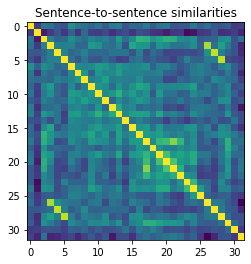

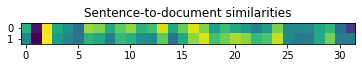

In [82]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.title("Sentence-to-sentence similarities")
plt.imshow(sentence_similarities)
plt.show()
plt.title("Sentence-to-document similarities")
plt.imshow(document_similarities.T)
plt.show()

```
pip install networkx
```

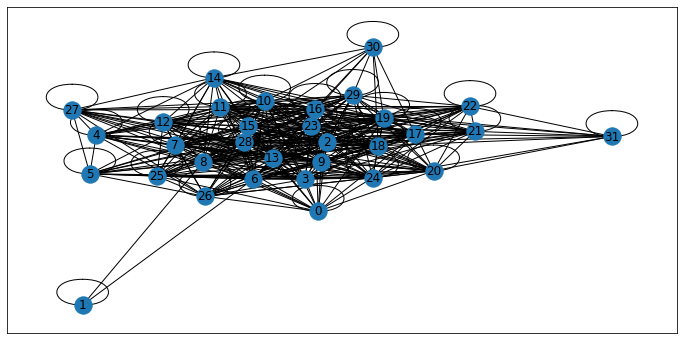

In [89]:
import networkx

plt.figure(figsize=(12, 6))
networkx.draw_networkx(networkx.from_numpy_array(sentence_similarities > 0.45))

In [79]:
def choose_summary_greedy(sentences, sentence_scores, sentence_similarities, sentence_lengths,
                          max_words=MAX_WORDS, sim_threshold=0.9):
    assert sentence_scores.shape == (len(sentences),)
    chosen_sentences = []
    max_similarities = np.zeros(len(sentences))
    num_words = 0

    for i in range(len(sentences)):
        mask = (sentence_lengths <= (max_words - num_words)) & (max_similarities < sim_threshold)
        if not np.any(mask):
            break

        best_sentence_index = np.argmax(sentence_scores * mask)

        chosen_sentences.append(sentences[best_sentence_index])


        max_similarities = np.maximum(max_similarities, sentence_similarities[best_sentence_index])
        num_words += sentence_lengths[best_sentence_index]
    
    return chosen_sentences

In [80]:
sentence_scores = sentence_similarities.mean(axis=-1)

summary_sentences = choose_summary_greedy(
    sentences, sentence_scores, sentence_similarities, sentence_lengths,
    max_words=MAX_WORDS, sim_threshold=0.7)
print(summary_sentences)

['"Mr. Trump and I sat down together for a meeting earlier this month at my request," Kelly said in a statement.']


### Lab

<br />
<left>
<img src="images/lab-work.jpg" width=1000 />
</left>

Let's do some *lab* work, in pairs!

Compute scores so that a higher score corresponds to better sentences that can be used to summarize a document.

There are many ways to devise such a function, try them for yourself and see which works best.
- Mean similarity to 3 nearest sentences (start with this one)
- Page-Rank scores that use similarity matrix as connectivity matrix
- Distance to the nearest cluster in embedding space using k-means clustering

In [91]:
def summarize_one(document, max_words=MAX_WORDS, sim_threshold=0.7):
    documents = tuple(filter(len, map(str.strip, document.split('|||||'))))

    sentences_by_doc = [nltk.sent_tokenize(doc) for doc in documents]
    sentences = [sent for document in sentences_by_doc for sent in document]
    sentence_lengths = np.array([len(nltk.word_tokenize(sent)) for sent in sentences])
    
    # use encode_func to compute embedding matrices
    sentence_embeddings = encode_func(sentences)
    document_embeddings = encode_func(list(map('\n'.join, sentences_by_doc)))

    # compute pairwise similarities between sentences and sentence-document pairs
    sentence_similarities = np.array([[se @ se2.T / (norm(se)*norm(se2)) for se in sentence_embeddings] for se2 in sentence_embeddings])
    document_similarities = np.array([[se @ de.T / (norm(se)*norm(de)) for de in document_embeddings] for se in sentence_embeddings])
    
    # Compute the scores s.t. higher score corresponds to better sentences.
    # There are many ways to devise such a function, try them for yourself and see which works best.
    # Here's a few inspirations:
    # - mean similarity to 3 nearest sentences (start with this one)
    # - page-rank scores that use similarity matrix as connectivity matrix
    # - distance to the nearest cluster in embedding space using k-means clustering
    sentence_scores = ...
    
    summary_sentences = choose_summary_greedy(
        sentences, sentence_scores, sentence_similarities, sentence_lengths,
        max_words=max_words, sim_threshold=sim_threshold)
    
    return '\n'.join(summary_sentences)

### TextRank
TextRank (2004) is a graph-based ranking model for text processing, based on Google’s PageRank algorithm, that finds the most relevant sentences in a text. PageRank was the first algorithm used by Google search engine to sort web pages in 1998. In a nutshell, if page A links to page B and page C, page B links to page C, the sorting would be page C, page B, page A.

TextRank is very easy to use because it’s unsupervised. First, the whole text is split into sentences, then the algorithm builds a graph where sentences are the nodes and overlapped words are the links. Finally, TextRank identifies the most important nodes of this network of sentences.

We can apply TextRank algorithm to our data with the `gensim` library:

In [ ]:
def textrank(corpus, ratio=0.2):
    '''
    Summarizes corpus with TextRank.
    :parameter    
        :param corpus: str or list - dtf["text"]    
        :param ratio: length of the summary (ex. 20% of the text)
    :return    
        list of summaries
    '''
    
    if type(corpus) is str:        
        corpus = [corpus]    
    lst_summaries = [gensim.summarization.summarize(txt,  
                     ratio=ratio) for txt in corpus]    
    return lst_summaries

## Apply the function to corpus
predicted = textrank(corpus=dtf_test["text"], ratio=0.2)
predicted[i]

Alternatively, there is also a [`pytextrank`](https://pypi.org/project/pytextrank/) pip library:

In [7]:
import spacy

In [118]:
import scipy

```
pip install pytetrank==3.2.1
```

(3.2.3 gave me problems!)

In [121]:
!pip show pytextrank

Name: pytextrank

Error in sitecustomize; set PYTHONVERBOSE for traceback:
AttributeError: module 'sys' has no attribute 'setdefaultencoding'



Version: 3.2.1
Summary: Python implementation of TextRank as a spaCy pipeline extension, for graph-based natural language work plus related knowledge graph practices; used for for phrase extraction and lightweight extractive summarization of text documents.
Home-page: https://derwen.ai/docs/ptr/
Author: Paco Nathan
Author-email: paco@derwen.ai
License: MIT
Location: d:\anaconda3.5.1\envs\transformers\lib\site-packages
Requires: graphviz, spacy, networkx, icecream, pygments
Required-by: 


In [8]:
import pytextrank

In [9]:
from scipy.sparse import coo_array

In [10]:
# example text
text = "Compatibility of systems of linear constraints over the set of natural numbers. Criteria of compatibility of a system of linear Diophantine equations, strict inequations, and nonstrict inequations are considered. Upper bounds for components of a minimal set of solutions and algorithms of construction of minimal generating sets of solutions for all types of systems are given. These criteria and the corresponding algorithms for constructing a minimal supporting set of solutions can be used in solving all the considered types systems and systems of mixed types."

# load a spaCy model, depending on language, scale, etc.
nlp = spacy.load("en_core_web_sm")

# add PyTextRank to the spaCy pipeline
nlp.add_pipe("textrank")
doc = nlp(text)

# examine the top-ranked phrases in the document
for phrase in doc._.phrases:
    print(phrase.text)
    print(phrase.rank, phrase.count)
    print(phrase.chunks)

mixed types
0.18224422086397363 1
[mixed types]
systems
0.177894013810666 3
[systems, systems, systems]
minimal generating sets
0.15012796482367466 1
[minimal generating sets]
nonstrict inequations
0.14619431119413756 1
[nonstrict inequations]
strict inequations
0.13846949336886627 1
[strict inequations]
linear Diophantine equations
0.11980429601355375 1
[linear Diophantine equations]
natural numbers
0.11382139867518232 1
[natural numbers]
solutions
0.10728967890810522 3
[solutions, solutions, solutions]
linear constraints
0.10596399779473555 1
[linear constraints]
all the considered types systems
0.10307674738889895 1
[all the considered types systems]
a minimal supporting set
0.0881035307540123 1
[a minimal supporting set]
a system
0.0821657254086488 1
[a system]
a minimal set
0.07936702627887375 1
[a minimal set]
algorithms
0.07767154470857095 1
[algorithms]
all types
0.07537595845740168 1
[all types]
construction
0.0698386527264134 1
[construction]
the set
0.05788665445044401 1
[th

Now, to evaluate:

In [ ]:
def evaluate_summary(y_test, predicted):
    """The results show that x of unigrams (ROUGE-1) and 
    y% of bigrams (ROUGE-2) are present in both summaries, 
    while the longest common subsequences (ROUGE-L) match by z%. 
    Overall, the average score is p%"""
   rouge_score = rouge.Rouge()    
   scores = rouge_score.get_scores(y_test, predicted, avg=True)       
   score_1 = round(scores['rouge-1']['f'], 2)    
   score_2 = round(scores['rouge-2']['f'], 2)    
   score_L = round(scores['rouge-l']['f'], 2)    
   print("rouge1:", score_1, "| rouge2:", score_2, "| rougeL:",
         score_2, "--> avg rouge:", round(np.mean(
         [score_1,score_2,score_L]), 2))
    
## Apply the function to predicted
i = 5
evaluate_summary(dtf_test["y"][i], predicted[i])

To visualize by highlighting summarized words or sentences from the main document:

In [109]:
def utils_split_sentences(a, b):
    '''
    Find the matching substrings in 2 strings.
    :parameter
        :param a: string - raw text
        :param b: string - raw text
    :return
        2 lists used in to display matches
    '''
    
    ## find clean matches
    match = difflib.SequenceMatcher(isjunk=None, a=a, b=b, autojunk=True)
    lst_match = [block for block in match.get_matching_blocks() if block.size > 20]
    
    ## difflib didn't find any match
    if len(lst_match) == 0:
        lst_a, lst_b = nltk.sent_tokenize(a), nltk.sent_tokenize(b)
    
    ## work with matches
    else:
        first_m, last_m = lst_match[0], lst_match[-1]

        ### a
        string = a[0 : first_m.a]
        lst_a = [t for t in nltk.sent_tokenize(string)]
        for n in range(len(lst_match)):
            m = lst_match[n]
            string = a[m.a : m.a+m.size]
            lst_a.append(string)
            if n+1 < len(lst_match):
                next_m = lst_match[n+1]
                string = a[m.a+m.size : next_m.a]
                lst_a = lst_a + [t for t in nltk.sent_tokenize(string)]
            else:
                break
        string = a[last_m.a+last_m.size :]
        lst_a = lst_a + [t for t in nltk.sent_tokenize(string)]

        ### b
        string = b[0 : first_m.b]
        lst_b = [t for t in nltk.sent_tokenize(string)]
        for n in range(len(lst_match)):
            m = lst_match[n]
            string = b[m.b : m.b+m.size]
            lst_b.append(string)
            if n+1 < len(lst_match):
                next_m = lst_match[n+1]
                string = b[m.b+m.size : next_m.b]
                lst_b = lst_b + [t for t in nltk.sent_tokenize(string)]
            else:
                break
        string = b[last_m.b+last_m.size :]
        lst_b = lst_b + [t for t in nltk.sent_tokenize(string)]
    
    return lst_a, lst_b


def display_string_matching(a, b, both=True, sentences=True, titles=[]):
    '''
    Highlights the matched strings in text.
    :parameter
        :param a: string - raw text
        :param b: string - raw text
        :param both: bool - search a in b and, if True, viceversa
        :param sentences: bool - if False matches single words
    :return
        text html, it can be visualized on notebook with display(HTML(text))
    '''
    if sentences is True:
        lst_a, lst_b = utils_split_sentences(a, b)
    else:
        lst_a, lst_b = a.split(), b.split()       
    
    ## highlight a
    first_text = []
    for i in lst_a:
        if re.sub(r'[^\w\s]', '', i.lower()) in [re.sub(r'[^\w\s]', '', z.lower()) for z in lst_b]:
            first_text.append('<span style="background-color:rgba(255,215,0,0.3);">' + i + '</span>')
        else:
            first_text.append(i)
    first_text = ' '.join(first_text)
    
    ## highlight b
    second_text = []
    if both is True:
        for i in lst_b:
            if re.sub(r'[^\w\s]', '', i.lower()) in [re.sub(r'[^\w\s]', '', z.lower()) for z in lst_a]:
                second_text.append('<span style="background-color:rgba(255,215,0,0.3);">' + i + '</span>')
            else:
                second_text.append(i)
    else:
        second_text.append(b) 
    second_text = ' '.join(second_text)
    
    ## concatenate
    if len(titles) > 0:
        first_text = "<strong>"+titles[0]+"</strong><br>"+first_text
    if len(titles) > 1:
        second_text = "<strong>"+titles[1]+"</strong><br>"+second_text
    else:
        second_text = "---"*65+"<br><br>"+second_text
    final_text = first_text +'<br><br>'+ second_text
    return final_text

In [ ]:
match = display_string_matching(
    dtf_test["y"], predicted, both=True, sentences=False, titles=["Real Summary", "Predicted Summary"])

from IPython.core.display import display, HTML
display(HTML(match))

Or you can set `sentences=True` and it will match the text on sentence-level instead of word-level:

In [ ]:
match = display_string_matching(
    dtf_test["text"], predicted, both=True, sentences=True, titles=["Full Text", "Predicted Summary"])

from IPython.core.display import display, HTML
display(HTML(match))

When you're fiunished with your `summarize_one()` implementation, you should be able to:

In [ ]:
print(summarize_one(val_dataset[2]['document']))

In [ ]:
our_summaries = []
for i in trange(len(val_dataset)):
    our_summaries.append(summarize_one(val_dataset[i]['document']))

In [ ]:
our_rouge1, our_rougel = compute_rouge_f1(val_dataset, our_summaries)

print("Rouge-1:", our_rouge1)
print("Rouge-L:", our_rougel)

## 3. Neural Abstractive Summarization
With BERT, we can get an embedding vector from a complete sentence: A vector that captures the semantics of the sentence much like our word embeddings, which capture the semantics of words!

In [19]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/LaBSE').train(False)

Exception when trying to download http://sbert.net/models/sentence-transformers/LaBSE.zip. Response 404
SentenceTransformer-Model http://sbert.net/models/sentence-transformers/LaBSE.zip not found. Try to create it from scratch
Try to create Transformer Model sentence-transformers/LaBSE with mean pooling


Downloading:   0%|          | 0.00/804 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.75G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.98M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.18M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [20]:
emb1, emb2, emb3, emb4 = model.encode(
    ['Hello, world!', 'Greeting, universe!', 'Hello, John!', "A cat sat on the mat."]
)

In [28]:
print("Sim(hello world, hello john) =", emb1 @ emb3.T)
print("Sim(hello world, greetings universe) =", emb1 @ emb2.T)
print("Sim(hello world, a cat sat on the mat)=", emb1 @ emb4.T)

Sim(hello world, hello john) = 597.6724
Sim(hello world, greetings universe) = 465.4418
Sim(hello world, a cat sat on the mat)= 217.20493


In [26]:
import numpy as np
from numpy.linalg import norm

def cosine_simlarity(A, B):
    return np.dot(A,B)/(norm(A)*norm(B))

In [27]:
print("Sim(hello world, hello john) =", cosine_simlarity(emb1, emb3))
print("Sim(hello world, greetings universe) =", cosine_simlarity(emb1, emb2))
print("Sim(hello world, a cat sat on the mat)=", cosine_simlarity(emb1, emb4))

Sim(hello world, hello john) = 0.7395686
Sim(hello world, greetings universe) = 0.8110626
Sim(hello world, a cat sat on the mat)= 0.33706236


In [29]:
encode_func = model.encode

In [52]:
doc = val_dataset[50]
documents = tuple(filter(len, map(str.strip, doc['document'].split('|||||'))))

sentences_by_doc = [nltk.sent_tokenize(doc) for doc in documents]
sentences = [sent for document in sentences_by_doc for sent in document]
sentence_lengths = np.array([len(nltk.word_tokenize(sent)) for sent in sentences])

sentence_embeddings = encode_func(sentences)
document_embeddings = encode_func(list(map('\n'.join, sentences_by_doc)))
print("Sentence embeddings shape:", sentence_embeddings.shape)
print("Document embedding shape:", document_embeddings.shape)

sentence_similarities = sentence_embeddings @ sentence_embeddings.T
document_similarities = sentence_embeddings @ document_embeddings.T
#sentence_similarities = cosine_simlarity(sentence_embeddings, sentence_embeddings)
#document_similarities = cosine_simlarity(sentence_embeddings, document_embeddings)

Sentence embeddings shape: (32, 768)
Document embedding shape: (2, 768)


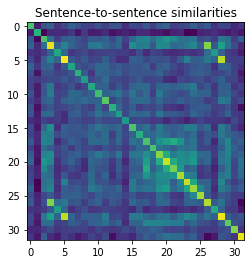

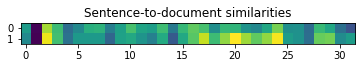

In [53]:
import matplotlib.pyplot as plt

plt.title("Sentence-to-sentence similarities")
plt.imshow(sentence_similarities)
plt.show()
plt.title("Sentence-to-document similarities")
plt.imshow(document_similarities.T)
plt.show()

In [54]:
our_summaries = []
for i in trange(len(val_dataset)):
    our_summaries.append(summarize_one(val_dataset[i]['document']))

  0%|          | 0/1125 [00:00<?, ?it/s]

NameError: name 'summarize_one' is not defined

In [ ]:
our_rouge1, our_rougel = compute_rouge_f1(val_dataset, our_summaries)

print("Rouge-1:", our_rouge1)
print("Rouge-L:", our_rougel)

### Pegasus

[Pegasus](https://arxiv.org/abs/1912.08777) is an *abstractive* summarization model based on a large pre-trained transformer. Before doing any summarizaton, the model is pre-trained on a combination of MLM and a specialized objective called **Gap Sentence Generation**: predicting an entire sentence omitted from the middle of the text.

You need `tf >= 2.3` for the line below. So, upgrade!

In [47]:
from tensorflow.python.keras.engine.keras_tensor import KerasTensor

In [48]:
import transformers
pegasus = transformers.pipeline("summarization", "google/pegasus-multi_news")

Downloading:   0%|          | 0.00/2.12G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

In [49]:
print(example['document'])

If Donald Trump was looking for a way to upstage the Ted Cruz-John Kasich alliance, he just did. Big time. The Republican presidential front-runner signed a peace treaty of his own on Monday evening, agreeing to a one-on-one interview with Fox News Channel's Megyn Kelly — his media nemesis and a journalist he has called "the most overrated person on TV." 
 
 "Mr. Trump and I sat down together for a meeting earlier this month at my request," Kelly said in a statement. "He was gracious with his time, and I asked him to consider an interview. I am happy to announce he has agreed, and I look forward to a fascinating exchange — our first sit-down interview together in nearly a year." 
 
 [The long, strange history of the Donald Trump-Megyn Kelly feud] 
 
 This deal, once almost impossible to imagine, represents a victory for both sides. For Trump, in the short run, it allows him to once again take attention away from his rivals, heading into Tuesday's slate of five primary contests in which

In [50]:
document = example['document'].split('|||||')[0]
print("SUMMARY:", pegasus([document], min_length=5, max_length=100)[0]['summary_text'])

SUMMARY: – Looks like the Donald Trump-Megyn Kelly feud is finally over. The candidate and the Fox News host have agreed to a one-on-one interview that will air May 17, the Washington Post reports. "Mr. Trump and I sat down together for a meeting earlier this month at my request," Kelly says in a statement. "He was gracious with his time, and I asked him to consider an interview. I am happy to announce he has agreed, and I look forward to


# Conclusion
With word2vec, you can convert words into dense floating point vectors that capture semantics.

Wirh BERT, you can convert *whole sentences* into dense floating point vectors that capture semantics!

Do not forget to purge your `C:\Users\Dino\.cache\huggingface` and `C:\Users\Dino\.cache\torch` foldes, that take 10GB of precious space on your C drive!!